# LAB 04 Assigment

Dominik Breksa (dominikbreksa@student.agh.edu.pl)

### Imports of libraries and packages

In [31]:
import numpy as np
import numpy.typing as npt
import scipy
import pint
import open_atmos_jupyter_utils
from matplotlib import pyplot as plt

In [32]:
plt.rcParams['axes.grid'] = True

si = pint.UnitRegistry()
si.setup_matplotlib()
si

### Physical Problem Definition

The physical problem, that I will model today is the temperature of the fluid (water) with convective and conductive heat transfer in one-dimensional spacial domain. Since the problem is one-dimensional, the computational domain will look like:

......................

To solve this problem, I will use the advection-diffusion parabolic partial differential equation (also called in our case simplified convection-conduction equation) ...

$$
\frac{\partial \psi}{\partial t} + u \frac{\partial \psi}{\partial x} - \mu \frac{\partial ^ 2 \psi}{\partial^2 x} = 0
$$

where,

- $t$ - time in seconds $[s]$,
- $x$ - spacial ...
- $\psi(x, t)$ - It is the function of temperature at a given point in one-dimensional space and time $[K]$,
- $u$ - Convection coefficient of the flow $[\frac{m}{s}]$,
- $\mu$ - Conduction coefficient $[\frac{m^2}{s}]$,
- $u \frac{\partial \psi}{\partial x}$ - Transport of heat by convection,
- $- \mu \frac{\partial ^ 2 \psi}{\partial^2 x}$ - Diffusive term which in our case is heat conduction.

and,

Conduction coefficient ($\mu$ term) is given by the following equation:

$$
\mu = \frac{K_w}{\rho_w c_w}
$$

$$
[\frac{W}{m K}\frac{1}{\frac{kg}{m^3}}\frac{1}{\frac{J}{kg K}} = \frac{W}{m K}\frac{m^3}{kg}\frac{kg K}{J} = \frac{W m^2}{J} = \frac{m^2}{s}]
$$

where,

- $K_w$ - is the thermal conductivity of water equal to: $0.60719479404817 [\frac{W}{m K}]$,
- $\rho_w$ - is the density of water equal to: $997.0474354081 [\frac{kg}{m^3}]$,
- $c_w$ - is the heat capacity of water at constant pressure equal to: $4181.9000614923 [\frac{J}{kg K}]$.

All values above are measured at the pressure of $0.1 MPa$ at the temperature of around $25^\circ C$.

##### Additional assumptions and simplifications

List of assumptions and simplifications of the model:

- The thermal conductivity, density and heat capacity of water are fixed (constant) and are not dependent on the temperature. It is not quite realistic, because in the real world this property of a fluid (water) is dependent on pressure and temperature.
- ...

##### Boundary conditions

List of boundary conditions that my model uses:

1. Left boundary condition, for example, for $\psi(x=0, t)$:

    $$
    \psi(x, t) = \psi_L(t) = T_o \qquad (t \ge 0; x \le 0)
    $$

2. Right boundary condition, for example, for $\psi(x=1, t)$:

    $$
    \psi(x, t) = \psi_R(t) = T_i \qquad (t \ge 0; x \ge 1)
    $$

The values of $T_o$ and $T_i$ are constant in time and space, and for my example are equal to $T_o = 50^\circ C$, $T_i = 0^\circ C$.

##### Initial conditions

List of initial conditions that my model uses:

$$
\psi(x, 0) = \psi_0(x) = T_i \qquad (0 \le x \le 1)
$$

In [33]:
from typing import Final

X_0: Final = 0.0
X_N: Final = 1.0

### Analytical solution

Here I present what the proof of the analytical solution to the advection-diffusion equation looks like. Since I have never had a differential equation course, I followed and argument with Martin Blunt from one of his YT videos. I have tried to add as much as possible from my side to give value and learn how the proof works. Hence, References at the bottom :)

1. Copy of the initial equation listed above (just moved the $\mu \frac{\partial ^ 2 \psi}{\partial^2 x}$ to the RHS):

    $$
    \frac{\partial \psi}{\partial t} + u \frac{\partial \psi}{\partial x} = \mu \frac{\partial ^ 2 \psi}{\partial^2 x}
    $$

2. Firstly, let's consider substituting (transforming) the variables in the above PDE, so instead of $x$ and $t$ we have $z$ and $t$, where $z$ is given by:

    $$
    z = x - ut
    $$

3. This substitution changes the $\frac{\partial \psi}{\partial x}$ term as follows (notice that $\frac{\partial z}{\partial x} = 1$, because the $t$ and $u$ is constant of $x$):

    $$
    \frac{\partial \psi}{\partial x} = \frac{\partial \psi}{\partial z} \frac{\partial z}{\partial x} = \frac{\partial \psi}{\partial z} 1 = \frac{\partial \psi}{\partial z}
    $$

4. This substitution changes the $\frac{\partial \psi}{\partial t}$ term as follows (notice that $\frac{\partial t}{\partial t} \Huge \vert_x \normalsize = 1$ and $\frac{\partial z}{\partial t} \Huge \vert_x \normalsize = -u$):

    $$
    \frac{\partial \psi}{\partial t} \Huge \vert_x \normalsize = \frac{\partial \psi}{\partial t} \Huge \vert_z \normalsize \frac{\partial t}{\partial t} \Huge \vert_x \normalsize + \frac{\partial \psi}{\partial z} \Huge \vert_t \normalsize \frac{\partial z}{\partial t} \Huge \vert_x \normalsize = \frac{\partial \psi}{\partial t} \Huge \vert_z \normalsize  + \frac{\partial \psi}{\partial z} \Huge \vert_t \normalsize \frac{\partial z}{\partial t} \Huge \vert_x \normalsize = \frac{\partial \psi}{\partial t} \Huge \vert_z \normalsize - u \frac{\partial \psi}{\partial z} \Huge \vert_t \normalsize
    $$

5. Applying the above substitutions to the equation at point $1$, we get the following (after simplifications we get purly diffusive equation):

    $$
    \frac{\partial \psi}{\partial t} - u \frac{\partial \psi}{\partial z} + u \frac{\partial \psi}{\partial z} = \frac{\partial \psi}{\partial t} = \mu \frac{\partial ^ 2 \psi}{\partial^2 z}
    $$

6. Then we perform another transformation of variables so that the equation above is changed from two independent variables ($z$ and $t$) to a single variable $\omega$, where $\omega$ is equal to:

    $$
    \omega = \frac{z}{\sqrt t}
    $$

7. This then changes the $\frac{\partial \psi}{\partial t}$ term to (notice that: $\frac{\partial \omega}{\partial t} = \frac{-z}{2 t \sqrt t} = \frac{- \omega}{2t}$):

    $$
    \frac{\partial \psi}{\partial t} = \frac{\mathrm{d} \psi}{\mathrm{d} \omega} \frac{\partial \omega}{\partial t} = \frac{- \omega}{2t} \frac{\mathrm{d} \psi}{\mathrm{d} \omega}
    $$

8. This then changes the $\frac{\partial \psi}{\partial z}$ term to (notice that: $\frac{\partial \omega}{\partial z} = \frac{1}{\sqrt t}$):

    $$
    \frac{\partial \psi}{\partial z} = \frac{\mathrm{d} \psi}{\mathrm{d} \omega} \frac{\partial \omega}{\partial z} = \frac{1}{\sqrt t} \frac{\mathrm{d} \psi}{\mathrm{d} \omega}
    $$

9. After the application of the above substitutions, the equation from point $5$ is (notice that: $\frac{\partial^2 \psi}{\partial^2 z} = \frac{1}{t} \frac{\mathrm{d}^2 \psi}{\mathrm{d}^2 \omega}$):

    $$
    \frac{- \omega}{2t} \frac{\mathrm{d} \psi}{\mathrm{d} \omega} = \frac{\mu}{t} \frac{\mathrm{d}^2}{\mathrm{d}^2 \omega}
    $$

    $$
    \frac{- \omega}{2} \frac{\mathrm{d} \psi}{\mathrm{d} \omega} = \mu \frac{\mathrm{d}^2}{\mathrm{d}^2 \omega}
    $$

10. We will be solving the second order differential by defining the term $y$ such that:

    $$
    y = \frac{\mathrm{d} \psi}{\mathrm{d} \omega}
    $$

11. This means that we can rewrite the equation from the previous point as:

    $$
    \frac{- \omega}{2} y = \mu \frac{\mathrm{d} y}{\mathrm{d} \omega}
    $$

    $$
    \frac{- \omega}{2 \mu} \mathrm{d} \omega = \frac{\mathrm{d} y}{y}
    $$

12. After preforming the integration, we get the following:

    $$
    \int \frac{- \omega}{2 \mu} \mathrm{d} \omega = \int \frac{\mathrm{d} y}{y}
    $$

    $$
    -\frac{\omega ^2}{4 \mu} + C_1 = \ln y + C_2
    $$

    $$
    -\frac{\omega ^2}{4 \mu} + C_1 - C_2 = \ln y
    $$

    $$
    y = e^{\Huge (- \frac{\omega ^2}{4 \mu} + C_1 - C_2)} = e^{\Huge (- \frac{\omega ^2}{4 \mu})}e^{\Huge C_1 - C_2} = ae^{\Huge (- \frac{\omega ^2}{4 \mu})} \qquad (a \gt 0)
    $$

13. Now we can try to find the function $\psi$, by finding the integral of $y$ (notice that: $erf(t) = \frac{2}{\sqrt \pi} \int_0^t e^{-s^2} \mathrm{d} s$):

    $$
    \psi(\omega) = a erf(\frac{\omega}{2 \sqrt \mu}) + C_3 = a erf(\frac{\omega}{2 \sqrt \mu}) + b
    $$

14. Given that $\lim_{x \to \inf} erf(x) = 1$, $\lim_{x \to -\inf} erf(x) = -1$ and the boundary conditions defined as in the problem definition, we can try to find the constants $a$ and $b$, by defining the following equations:

    $$
    T_i = a + b
    $$

    $$
    T_o = - a + b
    $$

15. Using some simple algebra, we can find that:

    $$
    a = T_i - \frac{T_o}{2} -\frac{T_i}{2} = \frac{T_i - T_o}{2} = - \frac{T_o - T_i}{2}
    $$

    $$
    b = \frac{T_o + T_i}{2}
    $$

16. Which finally lets us define the analytic solution as:

    $$
    \psi(\omega) = \frac{T_o + T_i}{2} - \frac{T_o - T_i}{2} erf(\frac{\omega}{2 \sqrt \mu})
    $$

    $$
    \psi(z, t) = \frac{T_o + T_i}{2} - \frac{T_o - T_i}{2} erf(\frac{\frac{z}{\sqrt t}}{2 \sqrt \mu}) = \frac{T_o + T_i}{2} - \frac{T_o - T_i}{2} erf(\frac{z}{2 \sqrt{t \mu}})
    $$

    $$
    \psi(x, t) = \frac{T_o + T_i}{2} - \frac{T_o - T_i}{2} erf(\frac{x - ut}{2 \sqrt{t\mu}})
    $$

After that, I will implement the solution as Python functions.

In [34]:
from typing import Callable


def create_initial_boundary_conditions[T: npt.DTypeLike](t_o: T, t_i: T) -> tuple[Callable[[T], T], Callable[[T], T], Callable[[T], T]]:
    """..."""

    def initial_conditions(x: T) -> T:
        """..."""

        nonlocal t_o
        nonlocal t_i

        return t_o if x <= 0 else t_i

    def left_boundary_conditions(t: T) -> T:
        """..."""

        nonlocal t_o

        return t_o

    def right_boundary_conditions(t: T) -> T:
        """..."""

        nonlocal t_i

        return t_i

    return initial_conditions, left_boundary_conditions, right_boundary_conditions

In [35]:
def create_analytic_solution(t_o, t_i, u, mu) -> Callable:
    """..."""

    def analytic_solution[T: npt.DTypeLike](x: npt.NDArray[T], t: npt.NDArray[T]) -> npt.NDArray[T]:

        nonlocal t_o
        nonlocal t_i

        omega = (x - mu * t) / np.sqrt(t)

        # pint 'Quantity' class with 'scipy.special.erf(...)' function does not work :) Valve please fix!
        return (t_o + t_i - (t_o - t_i) * scipy.special.erf((omega / 2. / u).magnitude)) / 2

    return analytic_solution


In [36]:
T_O: Final = np.float64(50.0 + scipy.constants.zero_Celsius) * si.K
T_I: Final = np.float64(0.0 + scipy.constants.zero_Celsius) * si.K

In [37]:
U: Final = np.float64(10. ** -6.) * si.m / si.s
U

<Quantity(1e-06, 'meter / second')>

In [38]:
MU: Final = np.float64(0.60719479404817 / 997.0474354081 / 4181.9000614923) * si.m * si.m / si.s
MU

<Quantity(1.45625882e-07, 'meter ** 2 / second')>

Since the analytic solution function with realworld values of $u$ and $\mu$ is no fun, because it looks very similar to very slow moving initial conditions (rectangle function). I propose to introduce new constant $u_{10000}$ and $\mu_{10000}$ that are just the same constants, but are 10,000 times greater (the time does not need to be absurd :)).

In [39]:
U_10000: Final = U * 10 ** 5
U_10000

<Quantity(0.1, 'meter / second')>

In [40]:
MU_10000: Final = MU * 10 ** 5
MU_10000

<Quantity(0.0145625882, 'meter ** 2 / second')>

In [41]:
INITIAL_CONDITIONS, LEFT_BOUNDARY_CONDITIONS, RIGHT_BOUNDARY_CONDITIONS = create_initial_boundary_conditions(T_O, T_I)

In [42]:
ANALYTIC_SOLUTIONS = create_analytic_solution(T_O, T_I, MU_10000, U_10000)

Example data, just to check if the equations are correct.

In [43]:
x = np.linspace(X_0, X_N, num=100, dtype=np.float64) * si.m


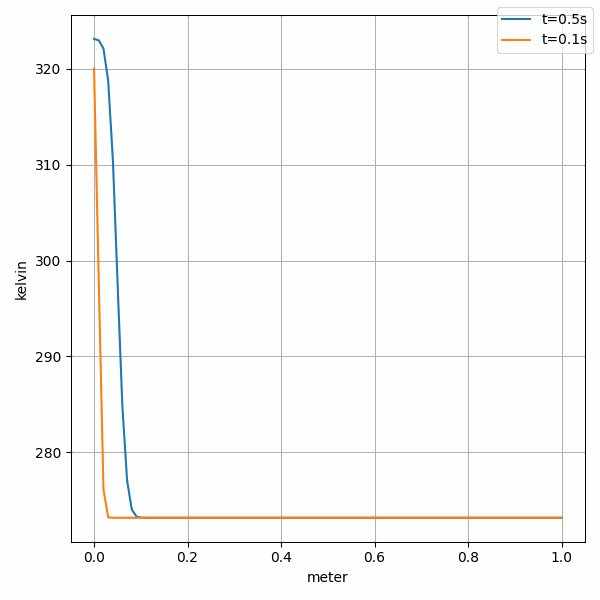

HTML(value="<a href='.\\tmpy0mljttk.gif' target='_blank'>.\\tmpy0mljttk.gif</a><br>")

In [44]:
from open_atmos_jupyter_utils import show_anim

def plot_only_analytic(step: int) -> plt.Figure:
    """..."""

    fig = plt.figure(figsize=(6, 6))
    fig.gca().plot(x, ANALYTIC_SOLUTIONS(x, 5 / 10 * si.s), label=f't={5 / 10}s')
    fig.gca().plot(x, ANALYTIC_SOLUTIONS(x, step / 10 * si.s), label=f't={step / 10}s')
    fig.legend()
    fig.tight_layout()

    return fig

show_anim(plot_only_analytic, range(1, 100))

### Numerical solution

I will use to solve this numerically the first order explicit upwind finite difference scheme for the advection-diffusion equation.

##### Discretion of the computational domain

Here I provide how I approximated the differences in the advection diffusion-equation:

1. The approximation of $\frac{\partial \psi}{\partial t}$ (first order approximation from Taylor series):

    $$
    \frac{\partial \psi}{\partial t} \approx \frac{\psi (x, t + 1 * \Delta t) - \psi (x, t)}{\Delta t}
    $$

2. The approximation of $\frac{\partial ^ 2 \psi}{\partial^2 x}$ (second order approximation from Taylor series):

    $$
    \frac{\partial ^ 2 \psi}{\partial^2 x} \approx \frac{\psi(x - 1 * \Delta x, t) - 2 \psi(x, t) + \psi(x + 1 * \Delta x, t)}{\Delta x^2}
    $$

3. The approximation of $\frac{\partial \psi}{\partial x}$ (first order approximation from Taylor series and Upwind):

    $$
    \frac{\partial \psi}{\partial x} \approx \frac{\psi(x, t) - \psi(x - 1 * \Delta x, t)}{\Delta x} \qquad (u \gt 0)
    $$

    $$
    \frac{\partial \psi}{\partial x} \approx \frac{\psi(x + 1 * \Delta x, t) - \psi(x, t)}{\Delta x} \qquad (u \lt 0)
    $$

Notice that to simplify the notation I will use the same as was in the laboratory classes:

$$
\psi(x + i * \Delta x, t + j * \Delta t) = \psi_i^j
$$

After using the approximations defined above, we get the following upwind equations (where the Courant number is: $C = u\frac{\Delta t}{\Delta x}$ and the Fourier number is: $F = D\frac{\Delta t}{\Delta x^2}$):

1. For $(u \gt 0)$:

    $$
    \frac{\psi_i^{j+1} - \psi_i^j}{\Delta t} + u \frac{\psi_i^j - \psi_{i-1}^j}{\Delta x} - \mu \frac{\psi_{i-1}^j - 2\psi_i^j + \psi_{i+1}^j}{\Delta x^2} = 0
    $$

    $$
    \frac{\psi_i^{j+1} - \psi_i^j}{\Delta t} = - u \frac{\psi_i^j - \psi_{i-1}^j}{\Delta x} + \mu \frac{\psi_{i-1}^j - 2\psi_i^j + \psi_{i+1}^j}{\Delta x^2}
    $$

    $$
    \psi_i^{j+1} - \psi_i^j = - u \Delta t \frac{\psi_i^j - \psi_{i-1}^j}{\Delta x} + \mu \Delta t \frac{\psi_{i-1}^j - 2\psi_i^j + \psi_{i+1}^j}{\Delta x^2}
    $$

    $$
    \psi_i^{j+1} = \psi_i^j - u \frac{\Delta t}{\Delta x}(\psi_i^j - \psi_{i-1}^j) + \mu \frac{\Delta t}{\Delta x^2}(\psi_{i-1}^j - 2\psi_i^j + \psi_{i+1}^j)
    $$

    $$
    \psi_i^{j+1} = (C + F)\psi_{i-1}^j + (1 - 2F - C) \psi_i^j + F \psi_{i+1}^j
    $$

2. For $(u \lt 0)$:

    $$
    \frac{\psi_i^{j+1} - \psi_i^j}{\Delta t} + u \frac{\psi_{i+1}^j - \psi_i^j}{\Delta x} - \mu \frac{\psi_{i-1}^j - 2\psi_i^j + \psi_{i+1}^j}{\Delta x^2} = 0
    $$

    $$
    \frac{\psi_i^{j+1} - \psi_i^j}{\Delta t} = - u \frac{\psi_{i+1}^j - \psi_i^j}{\Delta x} + \mu \frac{\psi_{i-1}^j - 2\psi_i^j + \psi_{i+1}^j}{\Delta x^2}
    $$

    $$
    \psi_i^{j+1} - \psi_i^j = - u \Delta t \frac{\psi_{i+1}^j - \psi_i^j}{\Delta x} + \mu \Delta t \frac{\psi_{i-1}^j - 2\psi_i^j + \psi_{i+1}^j}{\Delta x^2}
    $$

    $$
    \psi_i^{j+1} = \psi_i^j - u \frac{\Delta t}{\Delta x}(\psi_{i+1}^j - \psi_i^j) + \mu \frac{\Delta t}{\Delta x^2}(\psi_{i-1}^j - 2\psi_i^j + \psi_{i+1}^j)
    $$

    $$
    \psi_i^{j+1} = F\psi_{i-1}^j + (1 - 2F + C) \psi_i^j + (C + F)\psi_{i+1}^j
    $$

In [45]:
def numerical_solution[T: npt.NBitBase](x: np.ndarray, t: np.ndarray, dx: np.floating[T], dy: np.floating[T], u: np.floating[T], mu: np.floating[T], initial_condition: Callable, left_boundary_condition: Callable, right_boundary_condition: Callable) -> npt.NDArray[np.floating[T]]:



SyntaxError: incomplete input (469521508.py, line 2)

In [ ]:
NUM_X: Final = 500


In [ ]:
NUM_T: Final = 500

### Comparison of analytic and numerical solutions

##### Quantitative measure

##### Plot creation

### Literature & Learning materials

Here I present the literature

- [YT: "Explicit Upwind Finite Difference Solution to the Advection Equation" by Caspar Hewett](https://www.youtube.com/watch?v=drCdGxSG3Ec)
- [YT: "Implicit Upwind Finite Difference Solution to the Advection Equation" by Caspar Hewett](https://www.youtube.com/watch?v=CCY3ywCuGBI)
- [YT: "Finite Difference Schemes for Advection and Diffusion" by Caspar Hewett](https://www.youtube.com/watch?v=UM0o0ToluY8)
- [YT: "Stability & Accuracy of Numerical Schemes (2024)" by Caspar Hewett](https://www.youtube.com/watch?v=3ufzXpsxShU)
- [Link: "RÓWNANIA RÓŻNICZKOWE (A1) Skrypt dla studentów" by Andrzej Raczyński](https://www.math.uni.wroc.pl/sites/default/files/skrypt_rr1.pdf)
- [Book: "Analiza Numeryczna" by David Kincaid, Ward Cheney, isbn: 83-204-3078-X](https://www.impan.pl/~szczep/AMM1/Kincaid.pdf)
- [YT: "Advection diffusion equations" by Martin Blunt](https://www.youtube.com/watch?v=l_-YAEBXK1k)
- [YT: "Advection diffusion equation" by Martin Blunt](https://www.youtube.com/watch?v=MsTglR6Kqpg)
- [YT: "One dimensional advection diffusion equations" by Martin Blunt](https://www.youtube.com/watch?v=Jr3aOildCCA)
- [YT: "Molecular diffusion and Fick's law" by Martin Blunt](https://www.youtube.com/watch?v=Iaq9znRsusk)
- [Article: "Analytical solution of the advection–diffusion transport equation using a change-of-variable and integral transform technique" by J.S. Pérez Guerrero, L.C.G. Pimentel, T.H.Skaggs, M. Th.van Genuchten](https://doi.org/10.1016/j.ijheatmasstransfer.2009.02.002)
- [Article: "New International Formulation for the Thermal Conductivity of H2O" by M. L. Huber; R. A. Perkins; D. G. Friend; J. V. Sengers; M. J. Assael; I. N. Metaxa; K. Miyagawa; R. Hellmann; E. Vogel](https://doi.org/10.1063/1.4738955)
- [WebPage: CalcSteam by Berndt Wischnewski Richard-Wagner](https://www.peacesoftware.de/einigewerte/wasser_dampf_e.html)